In [55]:
# Library imports.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cluster import dbscan, KMeans, DBSCAN
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks
from scipy.stats import norm

# Urbansurge imports.
from urbansurge.data_acquisition import reflection_filter

In [2]:


def filter_reflections(y):
    """
    Filter Banner s18uuaq sensor data for reflections which show up as regular voltage jumps in the data.

    Parameter
        y : Sensor data read through a DAQ at the same sampling rate as the sensor.
    Return
        y_labels : Labels for y indexed from 0 where each label corresponds to a reflection level.
    """
    # Take the differences of y.
    y_diff = np.diff(y)

    # Sort the differences.
    sorted_diff = np.sort(abs(y_diff))

    # Difference the sorted differences.
    sorted_diff_diff = np.diff(sorted_diff)

    # Sort again.
    sorted_sorted_diff_diff = np.sort(sorted_diff_diff)

    # Find the maximum difference. This is the estimate of the shift.
    shift = np.max(sorted_diff_diff)
    shift = sorted_sorted_diff_diff[-1]

    # Histogram of differences.
    y_diff_hist, _ = np.histogram(y_diff, bins=31)

    # Find peaks of histogram. 
    hist_peaks, _ = find_peaks(y_diff_hist)

    # Retain peaks that are >5% of max peak.
    hist_peaks = hist_peaks[y_diff_hist[hist_peaks] > 0.05 * np.max(y_diff_hist[hist_peaks])]
    n_peaks = len(hist_peaks)
    print(n_peaks)

    plt.plot(y_diff_hist)
    plt.scatter(hist_peaks, y_diff_hist[hist_peaks])
    plt.show()

    # K-means clustering with k = number of peaks.
    kmeans = KMeans(n_clusters=n_peaks, random_state=0, n_init="auto").fit(y_diff.reshape(-1, 1))
    labels = kmeans.labels_

    # # DBScan data.
    # _, labels = dbscan(y_diff.reshape(-1, 1), eps=shift/1.5)

    print(labels.shape)
    print(y_diff.shape)

    # Compute means of differences with each label.
    unique_labels = np.unique(labels)
    print(unique_labels)
    unique_labels = unique_labels[unique_labels >= 0] # Don't process outlier points where label=-1.
    label_means = np.zeros(len(unique_labels))
    for i, ul in enumerate(unique_labels):
        label_means[i] = np.mean(y_diff[labels == ul])

    # Sort unique labels by label means.
    sort_label_means = np.sort(label_means)
    label_mean_sort_idx = np.argsort(label_means)
    sort_unique_labels = unique_labels[label_mean_sort_idx]

    # Index of label mean closest to 0.
    zero_idx = np.argmin(np.abs(sort_label_means - 0))

    # Shift indices.
    shift_lookup = dict(zip(sort_unique_labels, np.array(range(-zero_idx, zero_idx + 1))))
    shift_lookup[-1] = 0 # Outlier label is 0.
    shift_idx = np.array([shift_lookup[l] for l in labels])

    # Labels for y.
    y_labels = np.cumsum(np.insert(shift_idx, 0, 0))
    y_labels += np.abs(np.min(y_labels)) # Index from 0

    # Reassign outlier labels to -1.
    labels_append = np.insert(labels, 0, 0)
    y_labels[labels_append==-1] = -1

    return y_labels

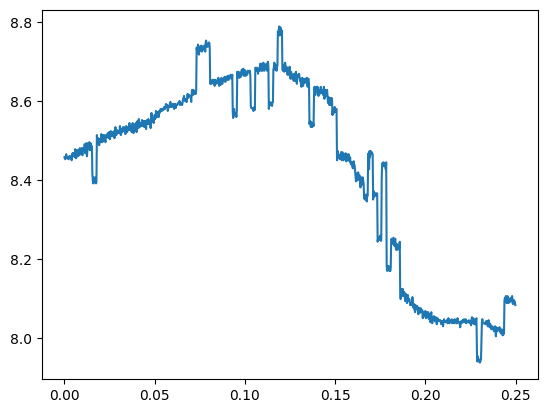

In [194]:
data_dir = Path(r'sensor_data')
fnames = [
    '21-Nov-2024_sensor_data4.csv',
    '21-Nov-2024_sensor_data0.csv'
]
data = [pd.read_csv(data_dir / f) for f in fnames]
df = data[0]

# Time stamps.
df['time'] = df['time'].str.replace(' sec', '').astype(float)
t = df['time'].to_numpy()

# Voltage readings from AI0 port.
v0 = df['V_ai0'].to_numpy()

# Voltage readings from AI1 port.
v1 = df['V_ai1'].to_numpy()

plotting_idx = 1000
plt.plot(t[:plotting_idx], v1[:plotting_idx])

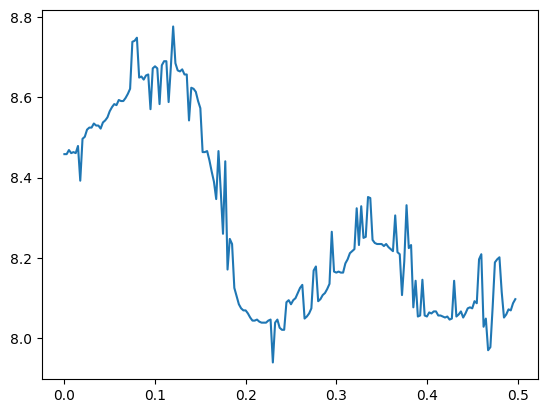

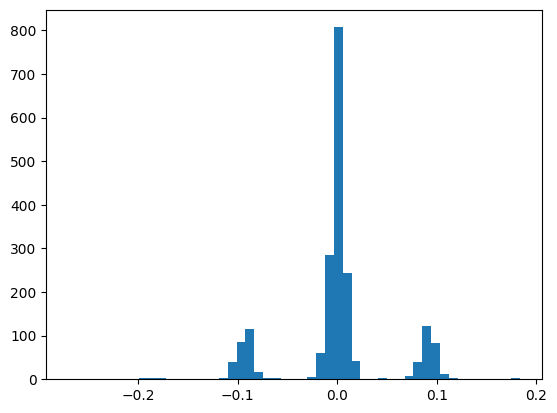

In [195]:
# Resample to 400 Hz if needed.

# Time step.
dt = t[1] - t[0]
fs = 1 / dt

# Resampled frequency.
fs_rs = 400
dt_rs = 1 / fs_rs

# Sampling interval.
skip = int(fs / fs_rs)

# Resampled signal.
t_rs = t[::skip]
v1_rs = v1[::skip]

i = 200
plt.plot(t_rs[:i], v1_rs[:i])
plt.show()

y_diff = np.diff(v1_rs)
t_diff = t_rs[:-1]

plt.hist(y_diff, bins=51)
plt.show()

ndiff = 1999, ydiff = 1976, outliers = 0
ndiff = 1976, ydiff = 1960, outliers = 0
ndiff = 1960, ydiff = 1957, outliers = 0
ndiff = 1957, ydiff = 1957, outliers = 0
[-0.09309232  0.00077133  0.092505  ]


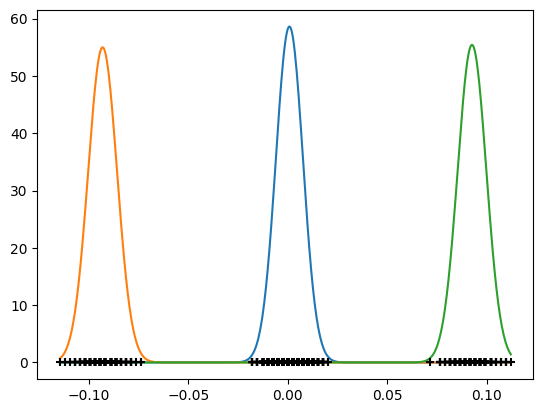

[ 0  0  0  0  0  0 -1  1  0  0  0  0  0  0  0  0  0  0  0  0]
[8 8 8 8 8 8 8 7 8 8 8 8 8 8 8 8 8 8 8 8]


ValueError: 'c' argument has 1958 elements, which is inconsistent with 'x' and 'y' with size 2000.

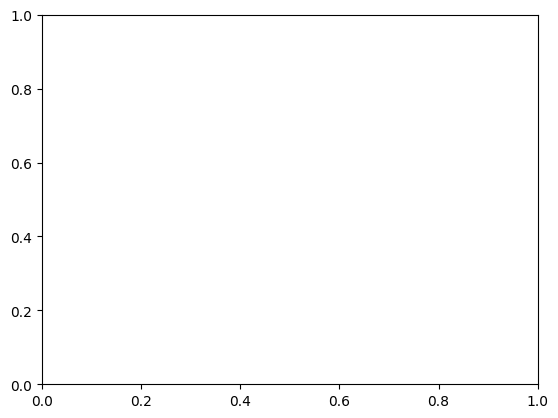

In [ ]:
# Data.
y = v1_rs

# Take the differences of y.
y_diff = np.diff(y)

# # Sort the differences.
# sorted_diff = np.sort(abs(y_diff))

# # Difference the sorted differences.
# sorted_diff_diff = np.diff(sorted_diff)

# # Sort again.
# sorted_sorted_diff_diff = np.sort(sorted_diff_diff)

# # Find the maximum difference. This is the estimate of the shift.
# shift = np.max(sorted_diff_diff)
# shift = sorted_sorted_diff_diff[-1]

# Histogram of differences.
y_diff_hist, bin_edges = np.histogram(y_diff, bins=31)

# Find peaks of histogram. 
hist_peaks, _ = find_peaks(y_diff_hist)

# Retain peaks that are >5% of max peak.
hist_peaks = hist_peaks[y_diff_hist[hist_peaks] > 0.05 * np.max(y_diff_hist[hist_peaks])]
peak_bin_edges = bin_edges[hist_peaks]
n_peaks = len(hist_peaks)

# AGW filter data with GMM.
N = 3.0  # Number of standard deviations to define outliers
ndiff = 0
n_init = np.size(y_diff)
outlier_idx = []  # To store indices of removed points
valid_idx = np.arange(len(y_diff))  # Start with all indices valid
while np.size(y_diff) != ndiff:
    # Update `ndiff`
    ndiff = np.size(y_diff)

    # Gaussian mixture with n_components = number of peaks
    gm = GaussianMixture(n_components=n_peaks, random_state=0, covariance_type='full').fit(y_diff.reshape(-1, 1))
    
    # Extract GMM parameters
    gm_means = gm.means_.flatten()
    gm_covariances = gm.covariances_.flatten()
    gm_std = np.sqrt(gm_covariances)

    # Identify points within N standard deviations
    new_valid_idx = []
    for idx, point in enumerate(y_diff):
        within_n_std = any(abs(point - mean) <= N * std for mean, std in zip(gm_means, gm_std))
        if within_n_std:
            new_valid_idx.append(idx)  # Retain valid indices

    new_valid_idx = np.array(new_valid_idx)

    valid_idx = valid_idx[new_valid_idx]
    
    # Update `y_diff` with only valid points
    y_diff = y_diff[new_valid_idx]

    print(f'ndiff = {ndiff}, ydiff = {np.size(y_diff)}, outliers = {len(outlier_idx)}')

    max_remove = 0.75
    if ndiff < max_remove * n_init:
        print(f'{int(max_remove * 100)}% of data removed. This is too much, check your data.')
        break

# Probability of all points.
labels = gm.predict(y_diff.reshape(-1, 1))

# # Remove points after outliers from y.
# y = y[valid_idx.flatten() + 1]
# y_diff = np.diff(y)

# Compute means of differences with each label.
unique_labels = np.unique(labels)
unique_labels = unique_labels[unique_labels >= 0] # Don't process outlier points where label=-1.

# Sort unique labels by label means.
sort_label_means = np.sort(gm_means, axis=0)
label_mean_sort_idx = np.argsort(gm_means, axis=0)
sort_unique_labels = unique_labels[label_mean_sort_idx]

print(sort_label_means)

# Index of label mean closest to 0.
zero_idx = np.argmin(np.abs(sort_label_means - 0))

# Shift indices.
shift_lookup = dict(zip(sort_unique_labels.flatten(), np.array(range(-zero_idx, zero_idx + 1))))
# shift_lookup[-1] = 0 # Outlier label is 0.
shift_idx = np.array([shift_lookup[l] for l in labels.flatten()])

# Labels for y.
y_labels = np.cumsum(np.insert(shift_idx, 0, 0))
y_labels += np.abs(np.min(y_labels)) # Index from 0

# # Add in outliers with label as -1.
# y_labels = np.insert(y_labels, outlier_idx.flatten()-1, -1)

# # Reassign outlier labels to -1.
# labels_append = np.insert(labels, 0, 0)
# y_labels[labels_append==-1] = -1

x = np.linspace(y_diff.min(), y_diff.max(), 500)
for mean, std in zip(gm.means_.flatten(), np.sqrt(gm.covariances_.flatten())):
    plt.plot(x, norm.pdf(x, mean, std), zorder=-1)
plt.scatter(y_diff, np.zeros_like(y_diff), marker='+', c='k')
plt.show()

print(shift_idx[:20])
print(y_labels[:20])

i = 250
j = 290

plt.scatter(np.arange(np.size(y)), y, c=y_labels)
plt.show()

# plt.plot(t_rs_inlier[i:j], v1_rs_inlier[i:j], 'k', zorder=-1)
# plt.scatter(t_rs_inlier[i:j], v1_rs_inlier[i:j], c=y_labels[i:j])
# plt.show()


# plt.scatter(t_rs, v1_rs)
# plt.scatter(t_rs[outlier_idx+1], v1_rs[outlier_idx+1], marker='+')
# plt.scatter(t_rs[outlier_idx], v1_rs[outlier_idx], marker='+')
# plt.show()
